In [1]:
pip install scikit-learn

Note: you may need to restart the kernel to use updated packages.


In [1]:
from skimage.draw import circle_perimeter_aa
import matplotlib.pyplot as plt
import torch
from tqdm.auto import tqdm
import torch.nn as nn
import torch.nn.functional as F

import torchvision
from torchvision import transforms
from torchvision.transforms import ToTensor 
device = "cuda" if torch.cuda.is_available() else "cpu"
device

/u/v/a/vaishnavi_b/Desktop/Circle-Detection-ML-Challenge-/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


'cuda'

In [2]:
from torch.utils.data import DataLoader, TensorDataset
from timeit import default_timer as timer
from src.model import CNNModel
from src.train import *
from src.utils import *
from src.prepare_data import *

In [3]:
# from prepare_data import generate_data, get_train_test_data


# data = generate_data(noise_level=0.1, img_size=100, num_samples=20000)

In [4]:
train_loader, test_loader = get_train_test_data(noise_level=0.1, img_size=100, num_samples=20000)

../data/noise_0.1_size_100_samples_20000.pkl
Using parameters: noise_level=0.1, img_size=100, min_radius=10, max_radius=50, dataset_path='ds'
Data saved to ../data/noise_0.1_size_100_samples_20000.pkl


/afs/cs.wisc.edu/u/v/a/vaishnavi_b/Desktop/Circle-Detection-ML-Challenge-/src/prepare_data.py:52: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:261.)
  X_train = torch.tensor(train_images, dtype=torch.float32).unsqueeze(1)


DataLoader: (<torch.utils.data.dataloader.DataLoader object at 0x7fc6de48c250>, <torch.utils.data.dataloader.DataLoader object at 0x7fc6de48c130>)
Length of train data loader: 500 batches of 32
Length of test data loader: 125 batches of 32


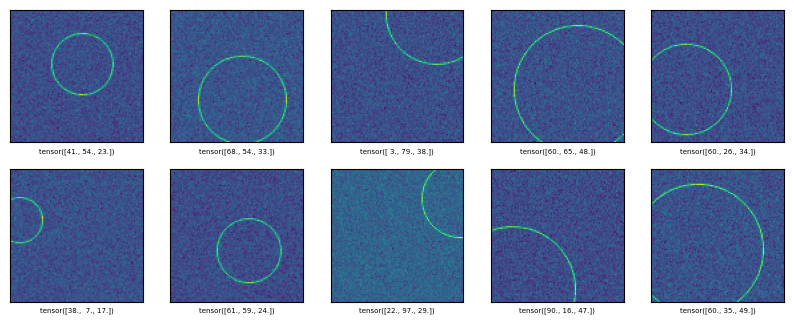

In [5]:
plt.figure(figsize=(10,10))
for i in range(10):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    train_features_batch, train_labels_batch = next(iter(train_loader))
    plt.imshow(train_features_batch[i].squeeze())
    plt.xlabel(train_labels_batch[i], fontsize = 5)

In [6]:
from torch import nn
class m0(nn.Module):
    def __init__(self, input_shape: int, hidden_units: int, output_shape: int):
        super().__init__()
        self.layer_stack = nn.Sequential(
            nn.Flatten(), # neural networks like their inputs in vector form
            nn.Linear(in_features=input_shape, out_features=hidden_units), # in_features = number of features in a data sample (784 pixels)
            nn.Linear(in_features=hidden_units, out_features=output_shape)
        )
    
    def forward(self, x):
        return self.layer_stack(x)

In [7]:
import torch.nn.functional as F
from torch import nn


class m1(nn.Module):
    def __init__(self, input_shape=1, hidden_units=64, output_shape=3, img_size=100):
        super().__init__()
        self.conv_block1 = nn.Sequential(
            nn.Conv2d(in_channels=input_shape, out_channels=hidden_units, kernel_size=3, padding=1, stride=1), # [1, 64]
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units*2, kernel_size=3, stride=1, padding=1), #[64, 128]
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv_block2 = nn.Sequential(
            nn.Conv2d(in_channels=hidden_units*2, out_channels=hidden_units*4, kernel_size=3, padding=1, stride=1),#[128, 256]
            nn.ReLU(),
            # nn.Conv2d(in_channels=hidden_units*4, out_channels=hidden_units*4, kernel_size=3, stride=1, padding=1),#[256, 256]
            # nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.out_layer = nn.Sequential(
            nn.Flatten(), # neural networks like their inputs in vector form
            nn.Linear(in_features=hidden_units*4*25*25, out_features=hidden_units), # in_features = number of features in a data sample (784 pixels)
            nn.Linear(in_features=hidden_units, out_features=output_shape)
        )

    def forward(self, x):
        x = self.conv_block1(x)
        # # print(x.shape)
        x = self.conv_block2(x)
        # # print(x.shape)
        x = self.out_layer(x)
        # print(x.shape)
        return x

In [8]:

# cuda.empty_cache()


model = m1().to(device)
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(),
                             lr = 0.0001)

In [9]:

%%capture captured_output

torch.manual_seed(42)
start_time= timer()
print("Hi")
epochs = 50
train_losses = []
test_losses = []
test_accs = []
epochs_ = []

for epoch in tqdm(range(epochs)):
    print(f"Epoch: {epoch}\n--------")
    train_loss, train_acc = train_step(model = model,
               data_loader=train_loader,
               loss_fn=loss_fn,
               optimizer=optimizer,
               calculate_accuracy=calculate_accuracy,
               device=device
               )

    test_loss, test_acc = test_step(model = model,
               data_loader=test_loader,
               loss_fn=loss_fn,
               calculate_accuracy=calculate_accuracy,
               device=device
               )

    epochs_.append(epoch)
    train_losses.append(train_loss.item())
    test_losses.append(test_loss.item())
    test_accs.append(test_acc)





    # Calculate training time
    end_time = timer()
    total_train_time_model = print_train_time(start=start_time,
                                                end=end_time,
                                                device=str(next(model.parameters()).device))
    
with open('output.txt', 'w') as f:
        f.write(captured_output.stdout)

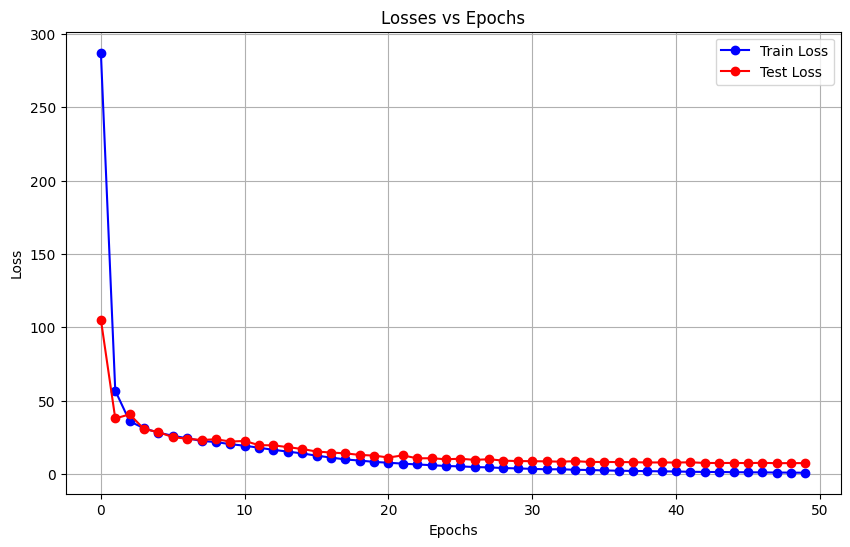

In [ ]:
import matplotlib.pyplot as plt

def plot_losses(epochs, train_losses, test_losses=None):
    plt.figure(figsize=(10, 6))
    
    plt.plot(epochs, train_losses, label='Train Loss', color='blue', marker='o')
    
    if test_losses:
        plt.plot(epochs, test_losses, label='Test Loss', color='red', marker='o')
    
    plt.title('Losses vs Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()



plot_losses(epochs_, train_losses, test_losses)


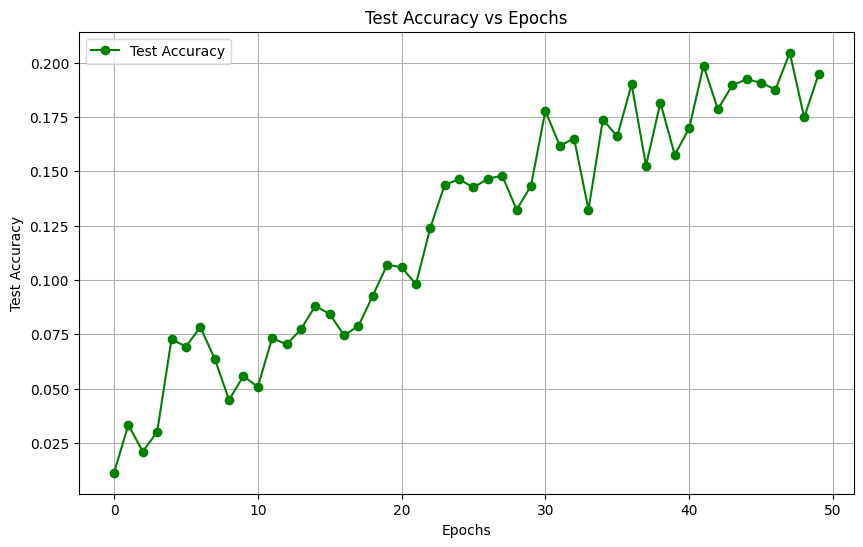

In [ ]:
import matplotlib.pyplot as plt

def plot_accuracy(epochs, test_accuracies):
    plt.figure(figsize=(10, 6))
    
    plt.plot(epochs, test_accuracies, label='Test Accuracy', color='green', marker='o')
    
    plt.title('Test Accuracy vs Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Test Accuracy')
    plt.legend()
    plt.grid(True)
    plt.show()

plot_accuracy(epochs_, test_accs)


In [15]:
test_accs

[0.01125,
 0.03325,
 0.021,
 0.03,
 0.07275,
 0.06925,
 0.07825,
 0.06375,
 0.04475,
 0.05575,
 0.05075,
 0.07325,
 0.07025,
 0.07725,
 0.088,
 0.08425,
 0.0745,
 0.07875,
 0.09275,
 0.107,
 0.10575,
 0.098,
 0.124,
 0.14375,
 0.14625,
 0.1425,
 0.1465,
 0.148,
 0.13225,
 0.14325,
 0.17775,
 0.16175,
 0.165,
 0.13225,
 0.17375,
 0.166,
 0.19,
 0.1525,
 0.1815,
 0.1575,
 0.16975,
 0.1985,
 0.1785,
 0.1895,
 0.19225,
 0.19075,
 0.1875,
 0.2045,
 0.17475,
 0.1945]